In [2]:
%load_ext autoreload

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
sys.path.append("../scripts/")  # Add the scripts folder to the path
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from data_preprocessing import clean_data, handle_outliers
from data_transform import convert_bytes_to_mb, rename_columns
from engagement_metrics import calculate_engagement_metrics, normalize_metrics, top_customers
from clustering import perform_kmeans_clustering, elbow_method, cluster_statistics, apply_kmeans_clustering
from traffic_analysis import aggregate_top_users_per_application
from visualizations import plot_top_3_applications, visualize_clusters

In [3]:
# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [4]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [5]:
telecom_data = clean_data(df)
print(telecom_data.info())
print(telecom_data.isnull().sum())  # Ensure there are no missing values
print(telecom_data.shape)          # Check the shape matches (148915, 44)


<class 'pandas.core.frame.DataFrame'>
Index: 148488 entries, 0 to 149999
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Bearer Id                       148488 non-null  object        
 1   Start                           148488 non-null  datetime64[ns]
 2   Start ms                        148488 non-null  float64       
 3   End                             148488 non-null  datetime64[ns]
 4   End ms                          148488 non-null  float64       
 5   IMSI                            148488 non-null  object        
 6   MSISDN/Number                   148488 non-null  object        
 7   IMEI                            148488 non-null  object        
 8   Last Location Name              148488 non-null  category      
 9   Avg RTT DL (ms)                 148488 non-null  float64       
 10  Avg RTT UL (ms)                 148488 non-null  float64     

In [6]:
# Select numeric columns
numeric_columns = telecom_data.select_dtypes(include=['float64', 'int64']).columns

# Treat outliers using the handle_outliers function
telecom_data = handle_outliers(telecom_data, numeric_columns)


In [7]:
# Define the renaming dictionary
rename_dict = {'Dur. (ms).1': 'Dur. (ms)'}

# Rename columns using the rename_columns function
telecom_data = rename_columns(telecom_data, rename_dict)

# Verify the column names
print(telecom_data.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms)',
       'Handset Manufacturer', 'Handset Type', 'Nb of sec with Vol DL < 6250B',
       'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)',
       'Other U

In [24]:
# Calculate engagement metrics
engagement_metrics = calculate_engagement_metrics(telecom_data)
print("Engagement Metrics:")
engagement_metrics.head(10)

Engagement Metrics:


,MSISDN/Number,session_frequency,session_duration,total_download_traffic,total_upload_traffic,total_traffic
0,3.360100e+10,1,116720140.0,8.426375e+08,3.605311e+07,8.786906e+08
1,3.360100e+10,1,181230963.0,1.207552e+08,3.610446e+07,1.568596e+08
2,3.360100e+10,1,134969374.0,5.566597e+08,3.930682e+07,5.959665e+08
3,3.360101e+10,1,49878024.0,4.019932e+08,2.032753e+07,4.223207e+08
4,3.360101e+10,2,37104453.0,1.363130e+09,9.428053e+07,1.457411e+09
5,3.360101e+10,2,253983077.0,5.552080e+08,6.000925e+07,6.152172e+08
6,3.360101e+10,2,128360523.0,5.530412e+08,6.846015e+07,6.215014e+08
7,3.360101e+10,1,86399977.0,2.940851e+08,3.857528e+07,3.326604e+08
8,3.360101e+10,2,495702147.0,8.965602e+08,9.357202e+07,9.901322e+08
9,3.360102e+10,1,124854778.0,6.853728e+08,4.709101e+07,7.324638e+08


In [25]:
# Report top 10 customers per engagement metric
top_frequency, top_duration, top_traffic = top_customers(engagement_metrics)

print("Top 10 Customers by Session Frequency:")
print(top_frequency)

print("Top 10 Customers by Session Duration:")
print(top_duration)

print("Top 10 Customers by Total Traffic:")
print(top_traffic)

Top 10 Customers by Session Frequency:
       MSISDN/Number  session_frequency  session_duration  \
13467   3.362632e+10                 18      2.846937e+09   
6404    3.361489e+10                 17      2.522231e+09   
13123   3.362578e+10                 17      2.380662e+09   
36907   3.365973e+10                 16      3.644357e+09   
76074   3.367588e+10                 15      3.036459e+09   
92581   3.376054e+10                 15      2.781709e+09   
64881   3.366716e+10                 13      1.829397e+09   
658     3.360313e+10                 12      2.050984e+09   
1270    3.360452e+10                 12      1.684601e+09   
13934   3.362708e+10                 12      2.135185e+09   

       total_download_traffic  total_upload_traffic  total_traffic  
13467            7.301517e+09           669650721.0   7.971167e+09  
6404             7.728750e+09           689483001.0   8.418233e+09  
13123            7.770043e+09           729577380.0   8.499621e+09  
36907        

In [26]:
# Normalize the metrics
normalized_metrics = normalize_metrics(engagement_metrics)
print(normalized_metrics.columns)



Index(['normalized_frequency', 'normalized_duration', 'normalized_traffic'], dtype='object')


In [27]:
# Perform K-means clustering
clusters = perform_kmeans_clustering(normalized_metrics)
print("K-Means Results:")
print(clusters.head())

K-Means Results:
   normalized_frequency  normalized_duration  normalized_traffic  cluster
0              0.000000             0.030127            0.099680        0
1              0.000000             0.047863            0.014574        0
2              0.000000             0.035144            0.066346        0
3              0.000000             0.011749            0.045873        0
4              0.058824             0.008237            0.167913        2


In [28]:
# Compute cluster statistics
cluster_stats = cluster_statistics(engagement_metrics.join(clusters['cluster']))
print("Cluster Statistics:")
print(cluster_stats)

Cluster Statistics:
   cluster  min_frequency  max_frequency  avg_frequency  total_frequency  \
0        0              1              2       1.041494            84084   
1        1              2             18       4.266932            17136   
2        2              1              4       2.176644            47268   

   min_duration  max_duration  avg_duration  total_duration  min_traffic  \
0     7142988.0  4.849145e+08  1.025824e+08    8.281889e+12   33249009.0   
1    66595562.0  3.644357e+09  5.230848e+08    2.100708e+12  774219442.0   
2    18235797.0  8.270170e+08  2.085606e+08    4.529102e+12  284218230.0   

    max_traffic   avg_traffic  total_traffic  
0  9.324271e+08  4.916532e+08   3.969313e+13  
1  8.514774e+09  2.240904e+09   8.999470e+12  
2  2.110991e+09  1.116952e+09   2.425572e+13  


In [29]:
top_users_per_app = aggregate_top_users_per_application(telecom_data)

# Access top users for a each application

# Loop through all applications and print top 10 users
for app, top_users in top_users_per_app.items():
    print(f"\nTop 10 users for {app}:")
    print(top_users)





Top 10 users for Social Media:
   MSISDN/Number  Social Media Total Traffic (Bytes)
0   3.362632e+10                        4.337478e+07
1   3.376054e+10                        3.975075e+07
2   3.365973e+10                        3.541236e+07
3   3.361489e+10                        2.829454e+07
4   3.362578e+10                        2.710312e+07
5   3.366716e+10                        2.424785e+07
6   3.378632e+10                        2.397492e+07
7   3.366907e+10                        2.380083e+07
8   3.360313e+10                        2.307782e+07
9   3.365849e+10                        2.300007e+07

Top 10 users for Google:
   MSISDN/Number  Google Total Traffic (Bytes)
0   3.362632e+10                  1.444374e+08
1   3.362578e+10                  1.402492e+08
2   3.361489e+10                  1.279738e+08
3   3.376054e+10                  1.211636e+08
4   3.365973e+10                  1.165163e+08
5   3.367588e+10                  1.098605e+08
6   3.378632e+10              

In [30]:
%autoreload 2


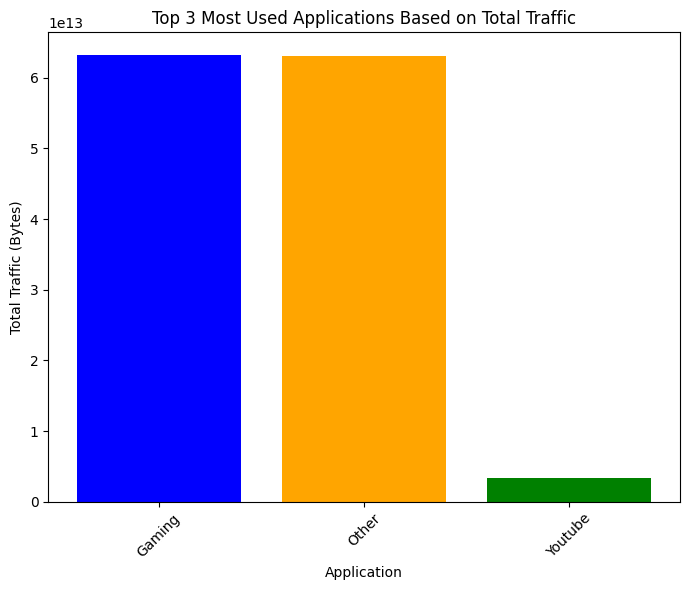

In [31]:
# Plot the top applications
plot_top_3_applications(telecom_data)

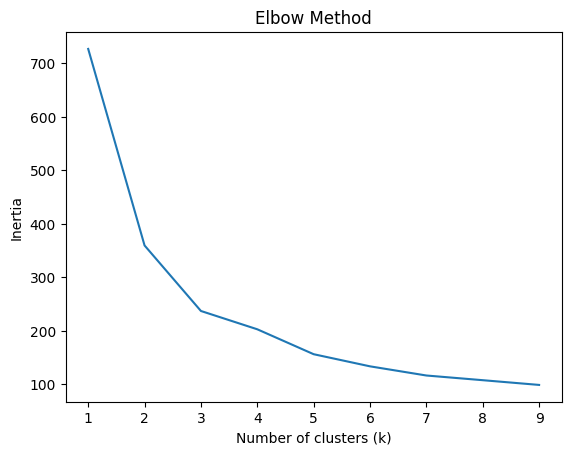

In [32]:
# Elbow method for optimal k
elbow_method(normalized_metrics[['normalized_frequency', 'normalized_duration', 'normalized_traffic']])



Cluster Centers:
[[0.06925673 0.05542072 0.12784583]
 [0.00244922 0.02624053 0.05405031]
 [0.1924038  0.14198643 0.26051531]]

First 5 rows with cluster labels:
   MSISDN/Number  Cluster
0   3.360100e+10        1
1   3.360100e+10        1
2   3.360100e+10        1
3   3.360101e+10        1
4   3.360101e+10        0


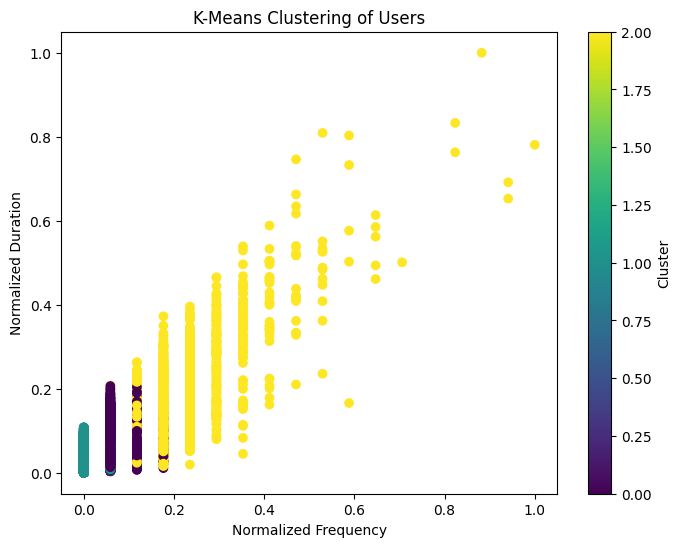

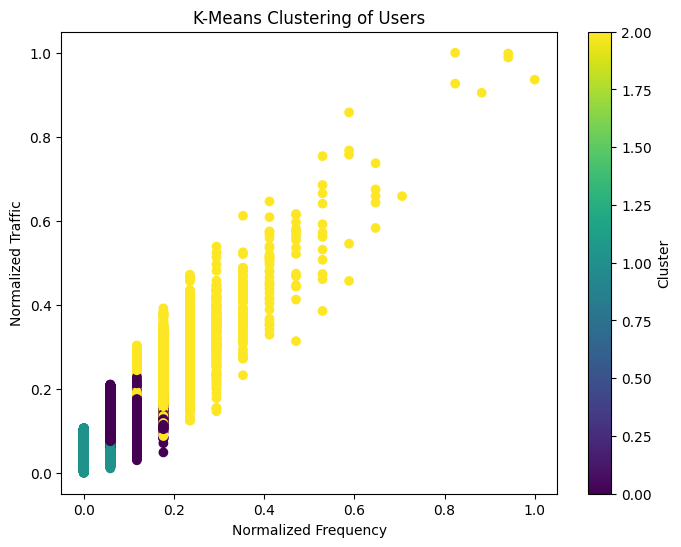

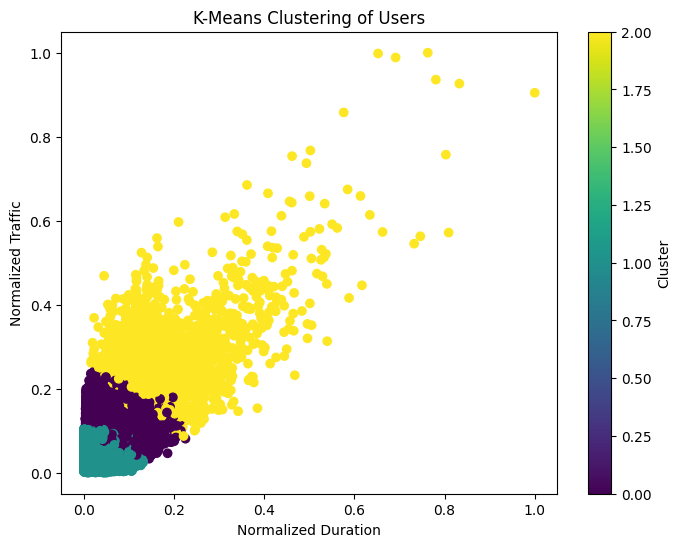

In [37]:


# Normalize and apply k-means
#normalized_metrics = normalized_data.copy()
normalized_metrics['MSISDN/Number'] = engagement_metrics['MSISDN/Number'].values  # Add this line


# Assign cluster labels to normalized_metrics
#normalized_metrics['Cluster'] = kmeans.labels_

# Optimal k from the elbow method
optimal_k = 3  

# Apply K-Means clustering
normalized_metrics, cluster_centers = apply_kmeans_clustering(normalized_metrics, optimal_k)

# Show the cluster centers and the assigned cluster labels
print("Cluster Centers:")
print(cluster_centers)

print("\nFirst 5 rows with cluster labels:")
print(normalized_metrics[['MSISDN/Number', 'Cluster']].head())

# Visualize the clusters
visualize_clusters(normalized_metrics, 'normalized_frequency', 'normalized_duration')
visualize_clusters(normalized_metrics, 'normalized_frequency', 'normalized_traffic')
visualize_clusters(normalized_metrics, 'normalized_duration', 'normalized_traffic')
